# Report

## Policy-Based Methods
Whereas *Value-Based Methods* like Deep Q-Learning are obtaining an optimal policy $\pi_*$ by trying to estimate the optimal action-value function, *Policy-Based Methods* directly learn the optimal policy.  
Besides this simplification another advantage of a Policy-Based Method is the fact that it is able to handle either stochastic or continuous actions.  
On the one hand Policy-Based Methods are using the *Monte Carlo* (MC) approach for the estimate of expected return:

$ G_t = R_{t+1} + R_{t+2} + ... + R_T$, if the discount factor $\gamma=1$

As $G_t$ is estimated with the full trajectory this yields to a high *variance*, but to a low *bias*.  
On the other hand Value-Based Methods are using the *Temporal Difference* (TD) approach to estimate the return:

$ G_t = R_{t+1} + G_{t+1}$ , if $\gamma=1$

Here $G_{t+1}$ is the estimated total return an agent will obtain in the next state. As the estimate of $G_t$ is always depending on the estimate of the next state, the variance of these estimates is low but biased.  
The pros of both methods can be combined in one single algorithm namely the Actor-Critic Method.

## Actor-Critic Methods
In Actor-Critic Methods one uses two function approximators (usually neural networks) to learn a policy (Actor) and a value function (Critic). The process looks as follows:  

1) Observe state $s$ from environment and feed into the Actor.  
2) The output are action probabilities $\pi(a|s;\theta_\pi)$. Select one action stochastically and feed back to the environment.  
3) Observe next state $s'$ and reward $r$.  
4) Use the tuple $(s, a, r, s')$ for the TD estimate $y=r + \gamma V(s'; \theta_v)$  
5) Train the Critic by minimizing the loss $L=(y - V(s;\theta_v)^2$.  
6) Calculate the advantage $A(s,a) = r + \gamma V(s'; \theta_v) - V(s; \theta_v)$.  
7) Train the Actor using the advantage.

## Deep Deterministic Policy Gradient
The following section refers to [Lillicrap et al., 2016].  
Deep Deterministic Policy Gradient (DDPG) combines the Actor-Critic approach with Deep Q-Learning. The actor function $\mu(s;\theta_\mu)$ gives the current policy. It maps states to continuous deterministic actions. The critic $Q(s,a;\theta_q)$ on the other hand is used to calculate action values and is learned using the Bellman equation. DDPG is also using a *replay buffer* and *target networks* which already helped to improve performance for Deep Q-Learning. In a finite replay buffer tuples of $(s, a, r, s')$ are stored and then batches are sampled from this buffer to apply for network updates. This tackles the issue of correlated tuples arrised from sequentially exploring the environment. Target networks are used to decouple the TD target from the current action value when performing neutwork updates. The target network is a copy of the Actor and Critic Network which are used to calculated the target. One approach is to update the weights of the target networks $\theta'$ with the weights $\theta$ of the Actor and Critic network periodically. An other approach is to perform *soft updates*:

$ \theta' \leftarrow \tau \theta + (1-\tau)\theta'$ with $\tau \ll 1$

In order to scale features *batch normalization* is being applied. This normalizes each dimension across the samples of the minibatch. An other important issue is handling exploration. By adding a noise process $N$ an exploration policy $\mu'$ is constructed:

$\mu'(s_t) = \mu(s_t;\theta_{\mu,t})+N$

The DDPG process looks as follows:  
1) Observe state $s$ from environment and feed to Actor.  
2) Select action $a = \mu(s;\theta_\mu) + N$ and feed back to environment.  
3) Observe next state $s'$ and reward $r$.  
4) Store transition $(s, a, r, s')$ in replay buffer and sample random minibatch of $n$ tuples. Calculate the TD estimate 
$y = r + \gamma Q'(s', \mu'(s';\theta_\mu');\theta_q')$  
5) Train the Critic by minimizing the loss 
$L=\mathbb{E} \big[\big(y - Q(s,a;\theta_q)\big)^2\big]$  
6) Train Actor with policy gradient 
$\mathbb{E} \big[\nabla_{\theta_\mu} Q(s,a;\theta_q) | s=s_t, a=\mu(s_t;\theta_\mu) \big] = \mathbb{E} \big[\nabla_a Q(s,a;\theta_q)|s=s_t,a=\mu(s_t) \nabla_{\theta_\mu} \mu(s;\theta_\mu)|s=s_t\big] $  
7) Update both target networks using soft update

As one see, this is an off-policy algorithm because the policy which is evaluated uses action $a=\mu'(s';\theta_\mu')$. This is different from the policy which selects action $a = \mu(s;\theta_\mu) + N$. An other interesting aspect is that the Critic network has only one output node, which is the action value given the state and the action: $Q(s,a;\theta_q)$ This is different to Deep Q-Learning where the Q-Network is mapping values to every possible (discrete) action node.

In [1]:
!pip -q install /python

In [2]:
import torch
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
from collections import deque

from agent import Agent

In [3]:
N = 2000
BUFFER_SIZE = int(1e7)
BATCH_SIZE = 256
GAMMA = .99
TAU = 1e-3
LEARNING_RATE_ACTOR = 1e-4
LEARNING_RATE_CRITIC = 1e-3
WEIGHT_DECAY = 0.0
SEED = 2

In [ ]:
def initialize_env(unity_file):
    # Initialize the environment
    env = UnityEnvironment(file_name=unity_file, worker_id=2)

    # Get default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    # Get state and action spaces
    env_info = env.reset(train_mode=True)[brain_name]
    state_size = env_info.vector_observations.shape[1]
    action_size = brain.vector_action_space_size
    n_agents = len(env_info.agents)
    
    print('State size: ', state_size)
    print('Action size: ', action_size)
    print('Number of agents: ', n_agents)
    
    return env, brain_name, state_size, action_size, n_agents

In [4]:
env, brain_name, state_size, action_size, n_agents = \
        initialize_env('/data/Reacher_Linux_NoVis/Reacher.x86')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


State size:  33
Action size:  4
Number of agents:  20


In [7]:
# Initialize agent
agent = Agent(state_size, action_size,
              n_agents, buffer_size=BUFFER_SIZE, 
              batch_size=BATCH_SIZE, gamma=GAMMA, tau=TAU,
              lr_a=LEARNING_RATE_ACTOR, lr_c=LEARNING_RATE_CRITIC,
              weight_decay=WEIGHT_DECAY, random_seed=SEED)

In [11]:
def ddpg(env, brain_name,
         agent, n_agents,
         n_episodes=2000, t_max=3000):
    """Deep Determinitic Policy Gradient.

    Params
    ======
        env: unity environment object
        brain_name (string): brain name of initialized environment
        agent: initialized agent object
        n_episodes (int): maximum number of training episodes
        t_max (int): maximum timesteps in episode
    """
    
    scores = []
    scores_window = deque(maxlen=100)
    for e in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agent.reset()
        score = np.zeros(n_agents)
        for _ in range(1, t_max):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            agent.step(state, action, reward, next_state, done)
            score += reward
            state = next_state
            if np.any(done):
                break

        # Relative score
        avg_score = np.mean(score)
        scores_window.append(avg_score)
        scores.append(avg_score)

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_window)), end="")
        if e % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_window)))
        if np.mean(scores_window)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e-100, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    return scores

In [ ]:
def plot_scores(scores_dict):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for key, scores in scores_dict.items():
        scores_smoothed = gaussian_filter1d(scores, sigma=5)
        plt.plot(np.arange(len(scores)), scores_smoothed, label=key)
    plt.ylabel('smoothed Score')
    plt.xlabel('Episode #')
    plt.legend()
    plt.show()

Episode 10	Average Score: 0.87
Episode 20	Average Score: 1.10
Episode 30	Average Score: 1.59
Episode 40	Average Score: 2.33
Episode 50	Average Score: 3.20
Episode 60	Average Score: 4.54
Episode 70	Average Score: 5.91
Episode 80	Average Score: 7.35
Episode 90	Average Score: 8.70
Episode 100	Average Score: 9.90
Episode 110	Average Score: 11.97
Episode 120	Average Score: 14.00
Episode 130	Average Score: 15.99
Episode 140	Average Score: 17.88
Episode 150	Average Score: 19.72
Episode 160	Average Score: 21.15
Episode 170	Average Score: 22.62
Episode 180	Average Score: 23.91
Episode 190	Average Score: 25.07
Episode 200	Average Score: 26.19
Episode 210	Average Score: 27.21
Episode 220	Average Score: 28.31
Episode 230	Average Score: 29.39
Episode 236	Average Score: 30.04
Environment solved in 236 episodes!


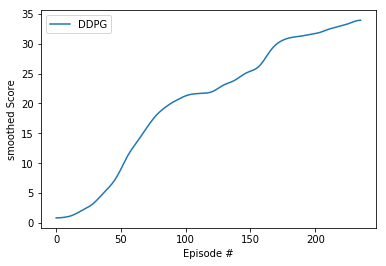

In [12]:
# Train agent
scores = ddpg(env, brain_name, agent, n_agents, n_episodes=N)

plot_scores({'DDPG': scores})

In [ ]:
env.close()

## Further potentials to improvement the RL agent
The algorithm took quite long to solve the environment. One potential option would be to reduce update frequency in order to achieve a more stable learning.  
Other algorithms that could solve this environment are  PPO, A3C and D4PG.

## References
- Lillicrap, T., Hunt, J., Pritzel, A., Heess, N., Erez, T., Tassa, Y., Silver, D., and Wiestra, D., Continuous Control with Deep Reinforcement Learning, arXiv:1509.02971v5 [cs.LG] 29 Feb 2016